# Восстановление золота из руды

**Описание проекта**

Необходимо разработать модель, предсказывающую коэффициент восстановления золота из золотосодержащей руды. Используя данные с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Описание данных**

Технологический процесс
* `Rougher feed` — исходное сырье

* `Rougher additions` (или reagent additions) — флотационные реагенты:
    * `Xanthate` — ксантогенат (промотер, или активатор флотации);
    * `Sulphate` — сульфат (на данном производстве сульфид натрия);
    * `Depressant` — депрессант (силикат натрия).
* `Rougher process` (англ. «грубый процесс») — флотация
* `Rougher tails` — отвальные хвосты
* `Float banks` — флотационная установка
* `Cleaner process` — очистка
* `Rougher Au` — черновой концентрат золота
* `Final Au` — финальный концентрат золота

Параметры этапов
* `air amount` — объём воздуха

* `fluid levels` — уровень жидкости
* `feed size` — размер гранул сырья
* `feed rate` — скорость подачи

**Наименование признаков**

`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:
* `rougher` — флотация

* `primary_cleaner` — первичная очистка
* `secondary_cleaner` — вторичная очистка
* `final` — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
* `input` — параметры сырья

* `output` — параметры продукта
* `state` — параметры, характеризующие текущее состояние этапа
* `calculation` — расчётные характеристики

<h1>План работы<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек-и-данных" data-toc-modified-id="Импорт-библиотек-и-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек и данных</a></span></li><li><span><a href="#Проверка-расчёта-эффективности-обогащения" data-toc-modified-id="Проверка-расчёта-эффективности-обогащения-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Проверка расчёта эффективности обогащения</a></span></li><li><span><a href="#Анализ-признаков,-недоступных-в-тестовой-выборке" data-toc-modified-id="Анализ-признаков,-недоступных-в-тестовой-выборке-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Анализ признаков, недоступных в тестовой выборке</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Предобработка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Концентрация-металлов-(Au,-Ag,-Pb)-на-различных-этапах-очистки" data-toc-modified-id="Концентрация-металлов-(Au,-Ag,-Pb)-на-различных-этапах-очистки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Концентрация металлов (Au, Ag, Pb) на различных этапах очистки</a></span></li><li><span><a href="#Сравнение-распределения-размеров-гранул-сырья-на-обучающей-и-тестовой-выборках" data-toc-modified-id="Сравнение-распределения-размеров-гранул-сырья-на-обучающей-и-тестовой-выборках-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках</a></span></li><li><span><a href="#Исследование-суммарной-концентрации-всех-веществ-на-разных-стадиях" data-toc-modified-id="Исследование-суммарной-концентрации-всех-веществ-на-разных-стадиях-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Исследование суммарной концентрации всех веществ на разных стадиях</a></span></li></ul></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span><ul class="toc-item"><li><span><a href="#Функции-для-вычисления-sMAPE" data-toc-modified-id="Функции-для-вычисления-sMAPE-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Функции для вычисления sMAPE</a></span></li><li><span><a href="#Обучение-и-оценка-разных-моделей" data-toc-modified-id="Обучение-и-оценка-разных-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение и оценка разных моделей</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li></ul></li></ul></div>

## Подготовка

### Импорт библиотек и данных

Импортируем библиотеки.

In [1]:
# gentleman's set
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import seaborn as sns
sns.set_theme(style='whitegrid')

import matplotlib.pyplot as plt
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titlelocation'] = 'left'
plt.rcParams.update({'font.size': 14})

# models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# metrics
from sklearn.metrics import mean_absolute_error, make_scorer

import warnings
warnings.filterwarnings('ignore')

# display
from IPython.display import display

Импортируем файлы.

In [2]:
try:  # local import
    df_train = pd.read_csv('./datasets/gold_recovery_train.csv')
    df_test = pd.read_csv('./datasets/gold_recovery_test.csv')
    df_full = pd.read_csv('./datasets/gold_recovery_full.csv')

except:  # from Praktikum server
    df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
    df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
    df_full = pd.read_csv('/datasets/gold_recovery_full.csv')
    
data = [df_train, df_test, df_full]
data_names = ['gold_recovery_train', 'gold_recovery_test', 'gold_recovery_full']

Посмотрим на данные в первом приближении.

In [ ]:
for idx, dataset in enumerate(data):
    print('====================')
    print(f'|| File name: {data_names[idx]}.csv, full duplicates: {dataset.duplicated().sum()}')
    display(dataset.head())
    dataset.info()
    print()

Мы имеем один датасет в трёх вариациях:  

* `df_full` – исходный датасет содержащий обучающую и тестовую выборки со всеми признаками.

* `df_train` – датасет с 3/4 данных, предназначенный для обучения модели;

* `df_test` – датасет c 1/4 данных для тестирования, в котором часть признаков недоступна.

Данные индексируются датой и временем получения информации (признак `date`).

### Проверка расчёта эффективности обогащения

$$
\mathbf{Recovery} = \frac{Concentrate * (Feed - Tail)}{Feed * (Concentrate - Tail)} * 100\%
$$

* `Concentrate` — доля золота в концентрате после флотации/очистки;

* `Feed` — доля золота в сырье/концентрате до флотации/очистки;

* `Tail` — доля золота в отвальных хвостах после флотации/очистки.

In [3]:
def recovery(row):
    conc = row['rougher.output.concentrate_au']
    feed = row['rougher.input.feed_au']
    tail = row['rougher.output.tail_au']

    try:
        recovery = (conc * (feed - tail)) / (feed * (conc - tail)) * 100
        if not 0 <= recovery <= 100:
            recovery = None
    except:
        recovery = None

    return recovery

In [4]:
calculated = df_train.apply(recovery, axis=1).dropna()
existing = df_train['rougher.output.recovery'].dropna()

mae = mean_absolute_error(calculated, existing)

print(f'Recovery comparison result, MAE: {mae:.2e} ({mae:.2f})')

Recovery comparison result, MAE: 9.30e-15 (0.00)


Для расчета признака необходимо знать данные о содержании золота в подаваемом сырье, а также о содержании золота в концентрате и отвальных хвостах. Таким образом, признак может быть расчитан только по завершении технологического цикла.

Ошибка MAE стремится к нулю, значит табличный признак посчитан корректно. Для расчета мы не брали аномальные значения `rougher.output.recovery` меньше 0 и больше 100, а также пропуски.

### Анализ признаков, недоступных в тестовой выборке

In [5]:
excess_features = set(df_train.columns) - set(df_test.columns)

print(f'Excess features count: {len(excess_features)}')
display(excess_features)

Excess features count: 34


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке недоступны признаки с типами `output` и `calculation`, которые сообщают измéренные и расчётные параметры продукта получившегося в результате одной из четырех технологических стадий очистки: `rougher`, `primary-` и `secondary cleaner`, `final`.

Можно сказать, что в тестовой выборке отделены признаки с целью недопустить утечку данных, так как скрытые признаки становятся известны лишь по завершении соответствующей технологической стадии очистки.

В качестве целевых признаков мы будем использовать `rougher.output.recovery` и `final.output.recovery`, они уже есть в обучающей выборке, но для тестовой выборки их необходимо извлекать из полного датасета. Для унификации подхода оставим в обоих выборках одинаковый набор признаков, а целевой признак в обоих случаях будем извлекать из полного датасета.

In [6]:
df_train = df_train[df_test.columns]

### Предобработка данных

Восстановим индексацию в выборках по признаку даты.

In [7]:
def date_to_index(date):
    return np.ceil(
        pd.to_datetime(date).astype(int) / 36e11 - 403560
    ).astype(int)

In [8]:
df_train['date'] = date_to_index(df_train['date'])
df_train.set_index('date', inplace=True)

In [9]:
df_test['date'] = date_to_index(df_test['date'])
df_test.set_index('date', inplace=True)

Оценим пропуски в интересующих нас признаках по полному датасету.

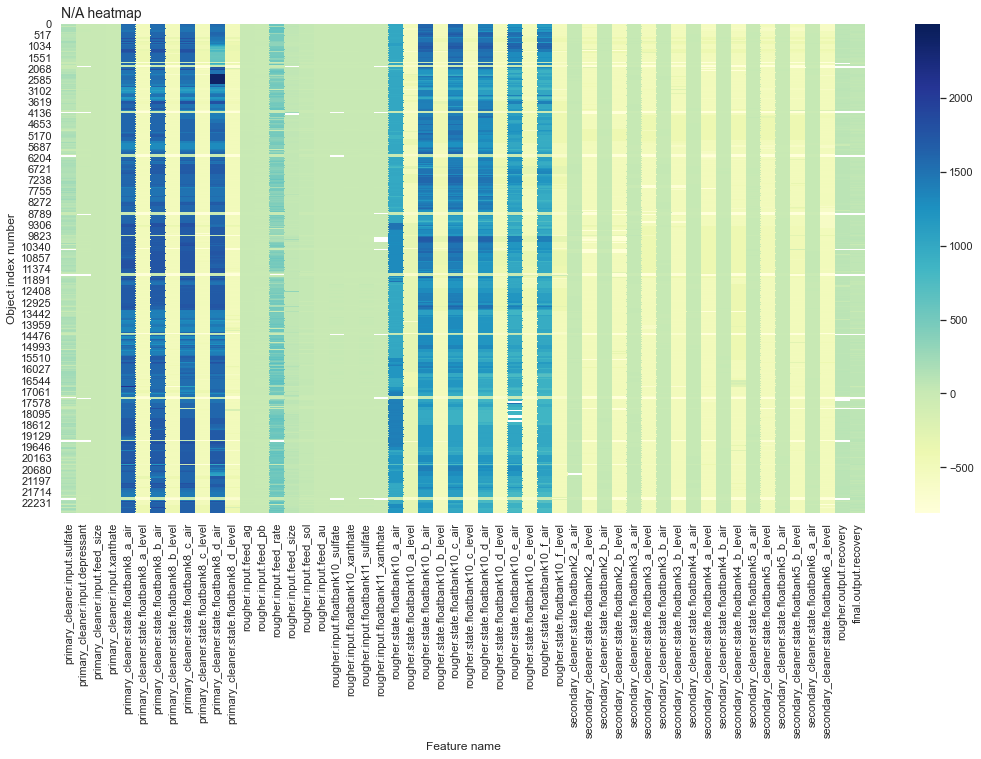

In [10]:
select = list(df_train.columns) + \
    ['rougher.output.recovery', 'final.output.recovery']

plt.figure(figsize=(18, 9))
sns.heatmap(df_full[select], cmap='YlGnBu')

plt.title('N/A heatmap')
plt.xlabel('Feature name')
plt.ylabel('Object index number')
plt.show()

На тепловой карте мы видим горизонтальные линии с нулевыми значениями через весь график. Нули на подаче сырья, на уровнях воздуха подаваемого во флотационную установку и пропуски в целевых принзнаках `rougher.output.recovery` и `final.output.recovery`.

Можно сделать предположение, что в эти периоды времени конвеер либо не работал совсем, либо база данных не получила соответствующие наблюдения с датчиков. Не стоит переживать, что мы потеряем какие-то ценные данные избавившись от пропусков, так как пропуски обнаруживаются на всю ширину объектов, поэтому просто избавимся от них в рабочих выборках.

In [11]:
select = df_full['rougher.output.recovery'].isna() | df_full['final.output.recovery'].isna()

index = df_full[select].index

df_train.drop(index, errors='ignore', inplace=True)
df_test.drop(index, errors='ignore', inplace=True)

print(f'df_train shape: {df_train.shape}')
print(f'df_test shape: {df_test.shape}')

df_train shape: (14149, 52)
df_test shape: (5290, 52)


Очевидно, что мы не будем использовать датасет целиком для обучения одной модели. Разделим признаки на наборы, которые будут использованы для предсказания `rougher.output.recovery` и `final.output.recovery`, назовём их `rougher_cols` и `final_cols`.

In [12]:
rougher_cols = [x for x in df_train.columns if x.startswith('rougher')]

final_cols = [x for x in df_train.columns if
              x.startswith('primary_cleaner') or x.startswith('secondary_cleaner')]

Оценим корреляцию признаков в обучающей выборке, по набору признаков `rougher_cols`.

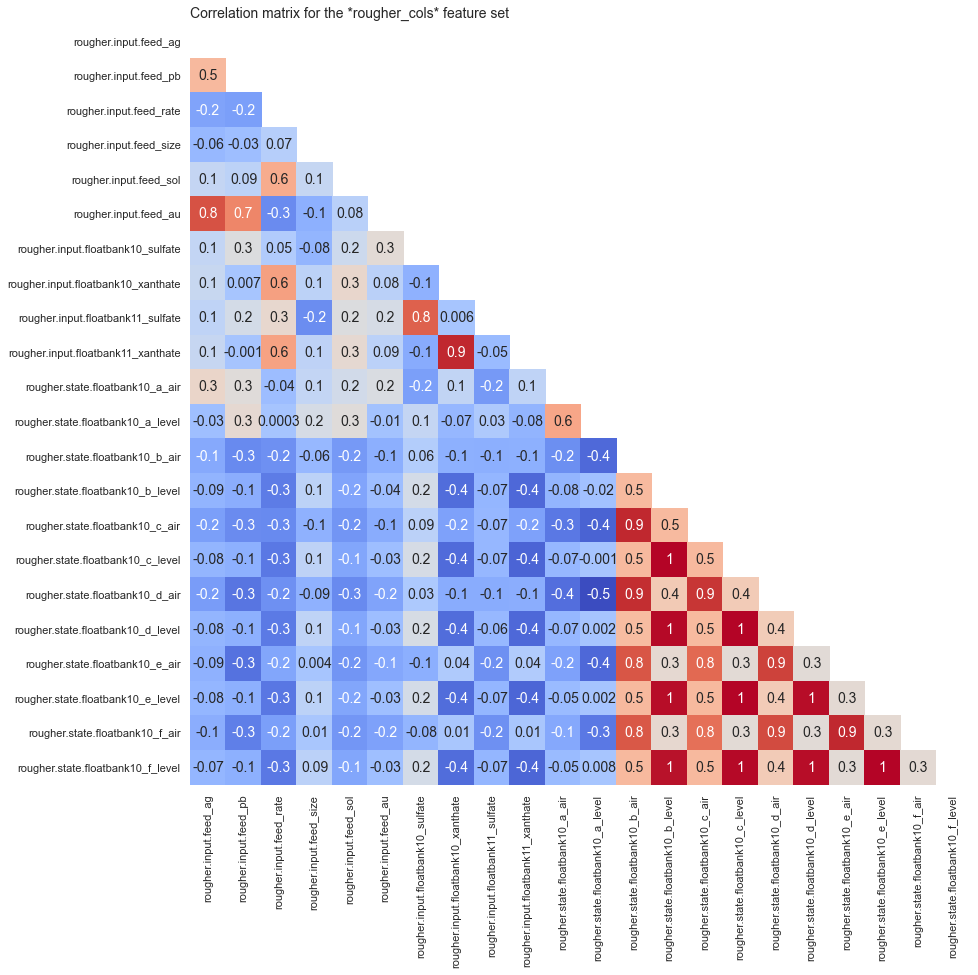

In [13]:
plt.figure(figsize=(14, 14))
matrix = np.triu(df_train[rougher_cols].corr())
sns.heatmap(df_train[rougher_cols].corr(), annot=True, mask=matrix,
            fmt='.1g', cmap='coolwarm', cbar=False)

plt.title('Correlation matrix for the *rougher_cols* feature set')
plt.show()

Запомним признаки с высокой коллинеарностью.

In [14]:
rougher_hi_corr_cols = [
    'rougher.input.feed_ag', 'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level'
]

Мы видим высокую корреляцию в трех группах: среди признаков описывающих параметры подаваемого сырья, параметры подаваемых реагентов и среди признаков описывающих показания датчиков в установке. 

Оценим распределение пропусков.

In [15]:
print('Распределение пропусков в df_train[rougher_cols]')
display(df_train[rougher_cols].isna().sum())

Распределение пропусков в df_train[rougher_cols]


rougher.input.feed_ag                   0
rougher.input.feed_pb                 100
rougher.input.feed_rate                 8
rougher.input.feed_size               144
rougher.input.feed_sol                 78
rougher.input.feed_au                   0
rougher.input.floatbank10_sulfate      29
rougher.input.floatbank10_xanthate      8
rougher.input.floatbank11_sulfate      36
rougher.input.floatbank11_xanthate    428
rougher.state.floatbank10_a_air         1
rougher.state.floatbank10_a_level       1
rougher.state.floatbank10_b_air         1
rougher.state.floatbank10_b_level       1
rougher.state.floatbank10_c_air         1
rougher.state.floatbank10_c_level       1
rougher.state.floatbank10_d_air         0
rougher.state.floatbank10_d_level       0
rougher.state.floatbank10_e_air       436
rougher.state.floatbank10_e_level       0
rougher.state.floatbank10_f_air         0
rougher.state.floatbank10_f_level       0
dtype: int64

In [16]:
print('Распределение пропусков в df_test[rougher_cols]')
display(df_test[rougher_cols].isna().sum())

Распределение пропусков в df_test[rougher_cols]


rougher.input.feed_ag                  0
rougher.input.feed_pb                  0
rougher.input.feed_rate                3
rougher.input.feed_size                1
rougher.input.feed_sol                21
rougher.input.feed_au                  0
rougher.input.floatbank10_sulfate      5
rougher.input.floatbank10_xanthate     0
rougher.input.floatbank11_sulfate      8
rougher.input.floatbank11_xanthate    25
rougher.state.floatbank10_a_air        0
rougher.state.floatbank10_a_level      0
rougher.state.floatbank10_b_air        0
rougher.state.floatbank10_b_level      0
rougher.state.floatbank10_c_air        0
rougher.state.floatbank10_c_level      0
rougher.state.floatbank10_d_air        0
rougher.state.floatbank10_d_level      0
rougher.state.floatbank10_e_air        0
rougher.state.floatbank10_e_level      0
rougher.state.floatbank10_f_air        0
rougher.state.floatbank10_f_level      0
dtype: int64

Где возможно воспользуемся избыточностью, в остальных случаях распространим вперед последнее имеющееся значение методом заполнения forward fill. Согласно примечанию к проекту о том, что соседние по времени параметры часто похожи, это может быть эффективной стратегией.

In [17]:
select = [
    ['rougher.input.floatbank10_sulfate', 'rougher.input.floatbank11_sulfate'],
    ['rougher.input.floatbank11_sulfate', 'rougher.input.floatbank10_sulfate'],
    ['rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_xanthate'],
    ['rougher.input.floatbank11_xanthate', 'rougher.input.floatbank10_xanthate'],
    ['rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_d_air']
]

for item in select:
    df_train[item[0]].fillna(df_train[item[1]], inplace=True)
    df_test[item[0]].fillna(df_test[item[1]], inplace=True)

df_train[rougher_cols] = df_train[rougher_cols].fillna(method='ffill')
df_test[rougher_cols] = df_test[rougher_cols].fillna(method='ffill')

Оценим корреляцию признаков в обучающей выборке, по набору признаков `final_cols`.

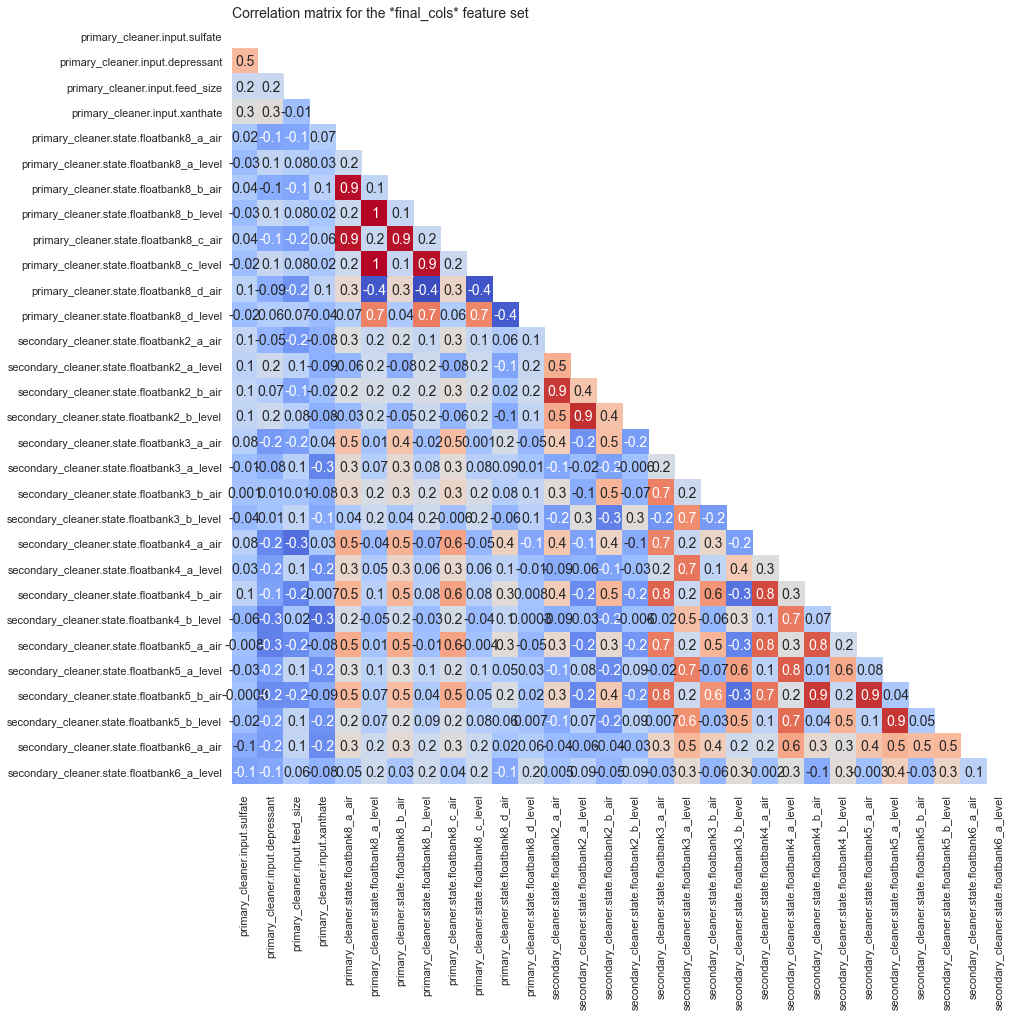

In [18]:
plt.figure(figsize=(14, 14))
matrix = np.triu(df_train[final_cols].corr())
sns.heatmap(df_train[final_cols].corr(), annot=True, mask=matrix,
            fmt='.1g', cmap='coolwarm', cbar=False)

plt.title('Correlation matrix for the *final_cols* feature set')
plt.show()

Запомним признаки с высокой коллинеарностью.

In [19]:
final_hi_corr_cols = [
    'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level',
    'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level',
    'secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank2_b_level',
    'secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank5_b_level',
]

Мы также видим высокую корреляцию признаков отвечающих за датчики внутри флотационных чанов. В матрице можно разглядеть одну группу, относящуюся к первой стадии очистки, и еще две, относящиеся ко второй стадии.

Оценим распределение пропусков.

In [20]:
print('Распределение пропусков в df_train[final_cols]')
display(df_train[final_cols].isna().sum())

Распределение пропусков в df_train[final_cols]


primary_cleaner.input.sulfate                  20
primary_cleaner.input.depressant               32
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                100
primary_cleaner.state.floatbank8_a_air          4
primary_cleaner.state.floatbank8_a_level        1
primary_cleaner.state.floatbank8_b_air          4
primary_cleaner.state.floatbank8_b_level        1
primary_cleaner.state.floatbank8_c_air          2
primary_cleaner.state.floatbank8_c_level        1
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_d_level        1
secondary_cleaner.state.floatbank2_a_air      217
secondary_cleaner.state.floatbank2_a_level      1
secondary_cleaner.state.floatbank2_b_air       21
secondary_cleaner.state.floatbank2_b_level      1
secondary_cleaner.state.floatbank3_a_air        4
secondary_cleaner.state.floatbank3_a_level      1
secondary_cleaner.state.floatbank3_b_air        1
secondary_cleaner.state.floatbank3_b_level      1


In [21]:
print('Распределение пропусков в df_test[final_cols]')
display(df_test[final_cols].isna().sum())

Распределение пропусков в df_test[final_cols]


primary_cleaner.input.sulfate                 4
primary_cleaner.input.depressant              5
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                4
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
secondary_cleaner.state.floatbank2_a_air      3
secondary_cleaner.state.floatbank2_a_level    0
secondary_cleaner.state.floatbank2_b_air      2
secondary_cleaner.state.floatbank2_b_level    0
secondary_cleaner.state.floatbank3_a_air      9
secondary_cleaner.state.floatbank3_a_level    0
secondary_cleaner.state.floatbank3_b_air      0
secondary_cleaner.state.floatbank3_b_level    0
secondary_cleaner.state.floatbank4_a_air

Заполним пропуски тем же подходом.

In [22]:
select = [
    ['secondary_cleaner.state.floatbank2_a_air', 'secondary_cleaner.state.floatbank2_b_air'],
    ['secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank2_a_air']
]

for item in select:
    df_train[item[0]].fillna(df_train[item[1]], inplace=True)
    df_test[item[0]].fillna(df_test[item[1]], inplace=True)
    
df_train[final_cols] = df_train[final_cols].fillna(method='ffill')
df_test[final_cols] = df_test[final_cols].fillna(method='ffill')

## Анализ

### Концентрация металлов (Au, Ag, Pb) на различных этапах очистки

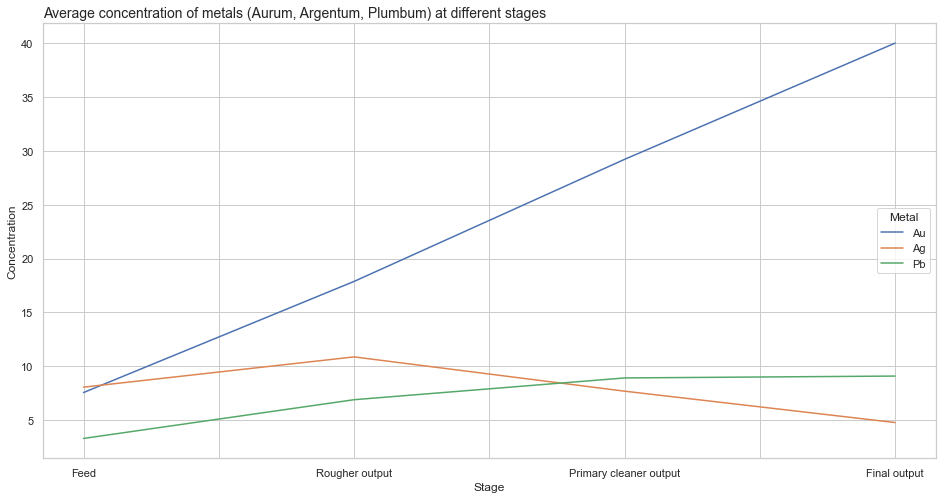

In [23]:
concentration = dict()
for prefix in ['au', 'ag', 'pb']:
    concentration.update(
        {f'{prefix.capitalize()}': {
            'Feed': df_full[f'rougher.input.feed_{prefix}'].mean(),
            'Rougher output': df_full[f'rougher.output.concentrate_{prefix}'].mean(),
            'Primary cleaner output': df_full[f'primary_cleaner.output.concentrate_{prefix}'].mean(),
            'Final output': df_full[f'final.output.concentrate_{prefix}'].mean()
        }
        })

concentration = pd.DataFrame(concentration)
concentration.plot(figsize=(16, 8))
plt.title('Average concentration of metals (Aurum, Argentum, Plumbum) at different stages')
plt.xlabel('Stage')
plt.ylabel('Concentration')
plt.legend(loc='center right', title='Metal')
plt.show()

Посмотрим на распределение в другом виде.

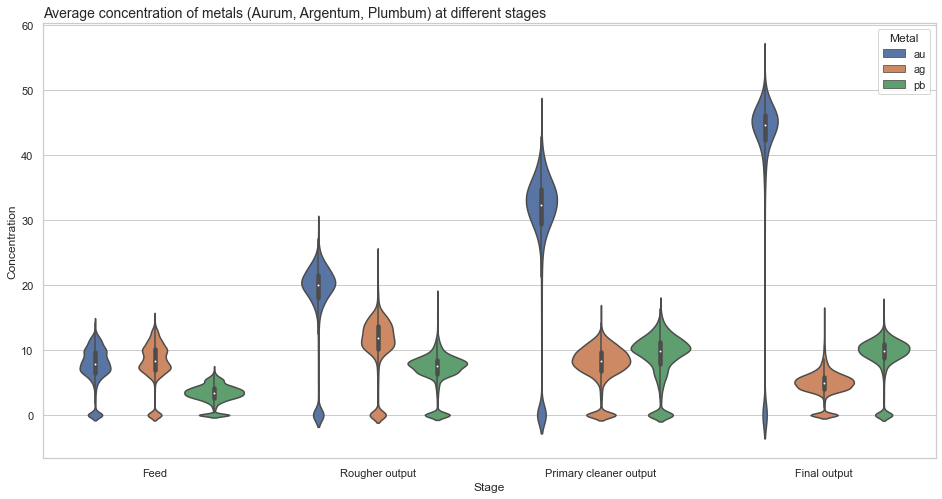

In [24]:
concentration_raw = pd.DataFrame()
for prefix in ['au', 'ag', 'pb']:
    concentration_raw = concentration_raw.append(
        pd.DataFrame(
            {'Metal': prefix,
             'Feed': df_full[f'rougher.input.feed_{prefix}'],
             'Rougher output': df_full[f'rougher.output.concentrate_{prefix}'],
             'Primary cleaner output': df_full[f'primary_cleaner.output.concentrate_{prefix}'],
             'Final output': df_full[f'final.output.concentrate_{prefix}']
             }
        ).melt(id_vars='Metal', var_name='Stage', value_name='Concentration')
    )
    
plt.figure(figsize=(16, 8))
sns.violinplot(data=concentration_raw, x='Stage', y='Concentration', hue='Metal')
plt.title('Average concentration of metals (Aurum, Argentum, Plumbum) at different stages')
plt.show()

На графике мы видим, что содержание золота в концентрате линейно растёт по мере очистки. Напрашивается очевидный вывод о том, что технология нацелена на извлечение из сырья именно этого металла. Однако мы также можем наблюдать, что содержание свинца сначала растёт в течении первых двух этапов очистки, а потом устанавливается на определенном уровне.

Таким образом:

* Концентрация золота (Aurum) в среднем линейно увеличивается на каждом этапе очистки.
* Концентрация серебра (Argentum) в среднем увеличивается после грубой очистки, а в процесссе тонкой очистки уменьшается.
* Концентрация свинца (Plumbum) в среднем увеличивается после первых двух этапов, и остается неизменным после третьего этапа очистки.

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

`rougher.input.feed_size`

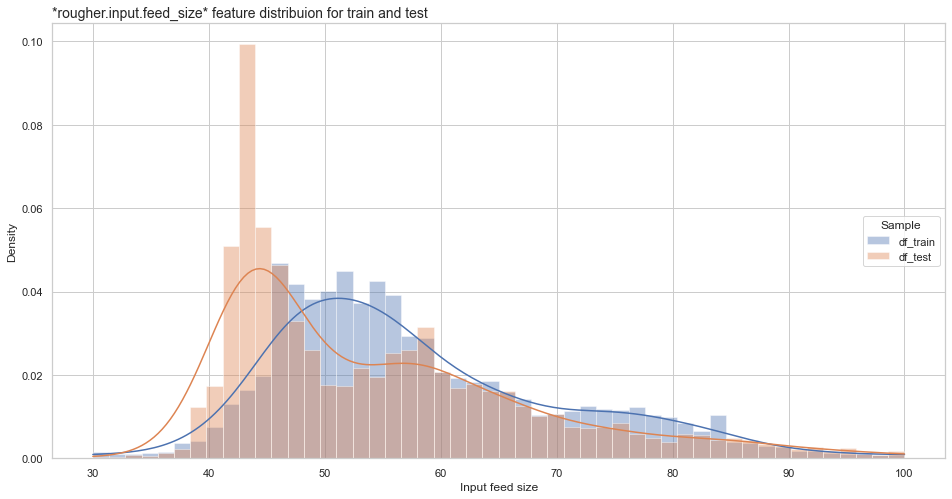

In [25]:
plt.figure(figsize=(16, 8))

size = (30, 100)

sns.distplot(x=df_train['rougher.input.feed_size'], label='df_train',
             hist_kws={'range': size}, kde_kws={'clip': size})
sns.distplot(x=df_test['rougher.input.feed_size'], label='df_test',
             hist_kws={'range': size}, kde_kws={'clip': size})

plt.title('*rougher.input.feed_size* feature distribuion for train and test')
plt.xlabel('Input feed size')
plt.legend(title='Sample', loc='center right')
plt.show()

`primary_cleaner.input.feed_size`

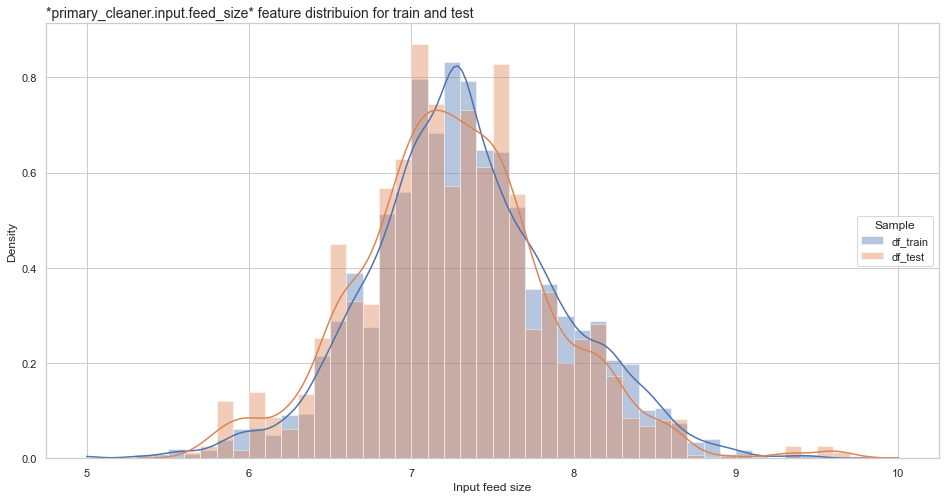

In [26]:
plt.figure(figsize=(16, 8))

size = (5, 10)

sns.distplot(x=df_train['primary_cleaner.input.feed_size'], label='df_train',
             hist_kws={'range': size}, kde_kws={'clip': size})
sns.distplot(x=df_test['primary_cleaner.input.feed_size'], label='df_test',
             hist_kws={'range': size}, kde_kws={'clip': size})

plt.title('*primary_cleaner.input.feed_size* feature distribuion for train and test')
plt.xlabel('Input feed size')
plt.legend(title='Sample', loc='center right')
plt.show()

Визуально выборки отличаются несущественно, значит мы можем использовать данные для модели.

### Исследование суммарной концентрации всех веществ на разных стадиях

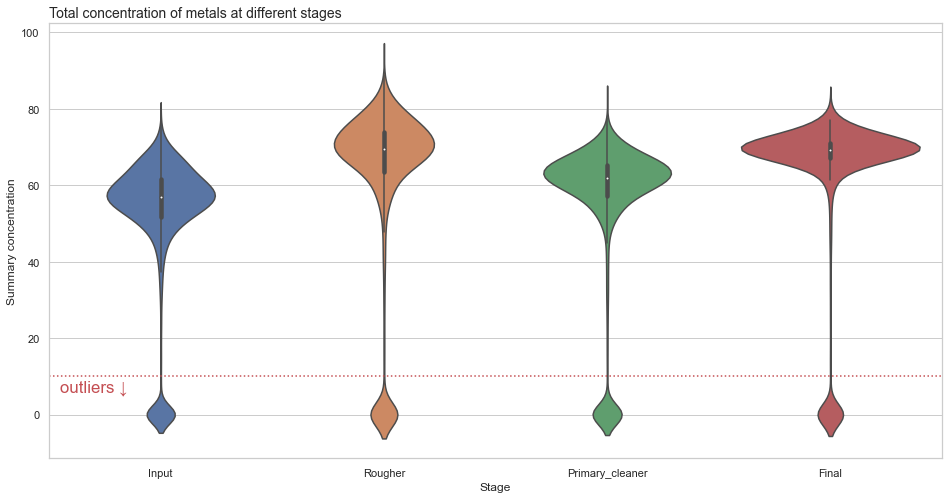

In [27]:
columns = ['Input', 'Rougher', 'Primary_cleaner', 'Final']
conc_sum = pd.DataFrame(
    np.zeros((len(df_full), len(columns))), columns=columns)

for prefix in ['au', 'ag', 'pb', 'sol']:
    conc_sum['Input'] += df_full[f'rougher.input.feed_{prefix}']
    conc_sum['Rougher'] += df_full[f'rougher.output.concentrate_{prefix}']
    conc_sum['Primary_cleaner'] += df_full[f'primary_cleaner.output.concentrate_{prefix}']
    conc_sum['Final'] += df_full[f'final.output.concentrate_{prefix}']

conc_sum_melted = conc_sum.melt(
    var_name='Stage', value_name='Summary concentration')

plt.figure(figsize=(16, 8))
sns.violinplot(x=conc_sum_melted['Stage'],
               y=conc_sum_melted['Summary concentration'])
plt.title('Total concentration of metals at different stages')
plt.axhline(y=10, ls=':', color='r')
plt.text(y=6, x=-.45, size='large', s='outliers ↓', color='r')
plt.show()

Линейная регрессия чувствительна к выбросам, поэтому мы обязаны убрать аномалии. Так как модель будет обучена на чистых данных, то и тестовую выборку мы должны очистить аналогично тому, как было на предыдущих шагах. В данном случае грубо отбросим объекты со значением общей концентрарии меньше 10.

In [28]:
select = 'Input < 10 or Rougher < 10 or Primary_cleaner < 10 or Final < 10'

index = conc_sum.query(select).index

df_train.drop(index, errors='ignore', inplace=True)
df_test.drop(index, errors='ignore', inplace=True)

print(f'df_train shape: {df_train.shape}')
print(f'df_test shape: {df_test.shape}')

df_train shape: (13571, 52)
df_test shape: (5111, 52)


## Модель

### Функции для вычисления sMAPE

**sMAPE** – (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

$$
\mathbf{sMAPE} = 
\frac{1}{N}
\sum_{i=1}^N
\frac{|y_i - \hat y_i|}{(|y_i| + |\hat y_i|)\ /\ 2} * 100\%
$$

In [29]:
def smape_score(y_true, y_pred):
    return (abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred))/2)).sum() / len(y_true)

$$
\mathbf{Итоговое\ sMAPE} = 25\%\ \mathbf{sMAPE}_{rougher} + 75\%\ \mathbf{sMAPE}_{final}
$$

In [30]:
def smape_closing_score(rougher, final):
    return 0.25*rougher + 0.75*final

In [31]:
smape = make_scorer(smape_score, greater_is_better=False)

### Обучение и оценка разных моделей

Необходимо спрогнозировать сразу две величины:

* эффективность обогащения чернового концентрата `rougher.output.recovery`;

* эффективность обогащения финального концентрата `final.output.recovery`.

Обучим по модели для прогнозирования каждого признака. В качестве метрики используем вручную инициализированную функцию `smape`.

In [32]:
def memorize(stage, model, smape, parameters):
    stats['stage'].append(stage)
    stats['model'].append(model)
    stats['smape'].append(abs(smape))
    stats['parameters'].append(parameters)

In [33]:
def run_ml():

    for estimator, param in zip(estimators, params):

        rs = GridSearchCV(estimator, param, scoring=smape, n_jobs=-1)

        regr = rs.fit(X_rougher, y_rougher)
        memorize('rougher', estimator, regr.best_score_, regr.best_params_)

        regr = rs.fit(X_final, y_final)
        memorize('final', estimator, regr.best_score_, regr.best_params_)

    display(pd.DataFrame
            .from_dict(stats, orient='index').transpose()
            .sort_values(by='smape'))

Выберем модели и зададим параметры поиска.

In [34]:
estimators = [
    DummyRegressor(),
    LinearRegression(),
    RandomForestRegressor(random_state=42)
]

params = [
    dict(strategy=['mean']),
    dict(),
    dict(
        n_estimators=list(range(30, 60+1, 5)),
        max_depth=list(range(2, 14+2, 2))
    )
]

Вариант обучения без удаления признаков с высокой коллинеарностью.

In [35]:
stats = dict(stage=[], model=[], smape=[], parameters=[])

X_rougher = df_train[rougher_cols]
y_rougher = df_full.loc[df_train.index, 'rougher.output.recovery']

X_final = df_train[final_cols].join(y_rougher)
y_final = df_full.loc[df_train.index, 'final.output.recovery']

# run_ml()

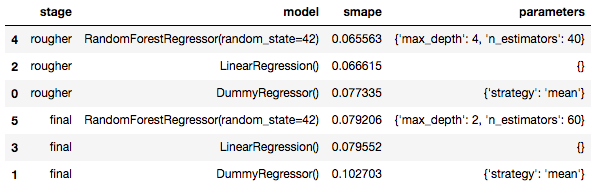

Вариант обучения с удалением признаков с высокой коллинеарностью.

In [36]:
stats = dict(stage=[], model=[], smape=[], parameters=[])

X_rougher = df_train[ set(rougher_cols) - set(rougher_hi_corr_cols) ]
y_rougher = df_full.loc[df_train.index, 'rougher.output.recovery']

X_final = df_train[ set(final_cols) - set(final_hi_corr_cols) ].join(y_rougher)
y_final = df_full.loc[df_train.index, 'final.output.recovery']

run_ml()

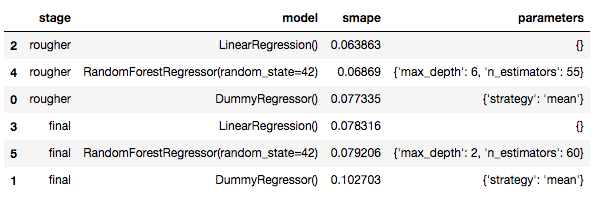

### Тестирование лучшей модели

In [37]:
stats = dict(stage=[], model=[], smape=[], parameters=[])

# Data
X_rougher_t = df_test[ set(rougher_cols) - set(rougher_hi_corr_cols) ]
y_rougher_t = df_full.loc[df_test.index, 'rougher.output.recovery']

X_final_t = df_test[ set(final_cols) - set(final_hi_corr_cols) ].join(y_rougher_t)
y_final_t = df_full.loc[df_test.index, 'final.output.recovery']


# LinearRegression()
regr = LinearRegression().fit(X_rougher, y_rougher)
memorize('rougher', regr, smape_score(
    y_rougher_t, regr.predict(X_rougher_t)), 'None')

regr = LinearRegression().fit(X_final, y_final)
memorize('final', regr, smape_score(
    y_final_t, regr.predict(X_final_t)), 'None')


# DummyRegressor()
dummy = DummyRegressor(strategy='mean').fit(X_rougher, y_rougher)
memorize('rougher', dummy, smape_score(
    y_rougher_t, dummy.predict(X_rougher_t)), 'None')

dummy = DummyRegressor(strategy='mean').fit(X_final, y_final)
memorize('final', dummy, smape_score(
    y_final_t, dummy.predict(X_final_t)), 'None')


# Output
display(pd.DataFrame
        .from_dict(stats, orient='index').transpose()
        .sort_values(by='smape'))

print(f"Итоговый sMAPE на тестовых данных: {smape_closing_score(*stats['smape'][:2]):.1%}")
print(f"Dummy sMAPE: {smape_closing_score(*stats['smape'][2:]):.1%}")

,stage,model,smape,parameters
0,rougher,LinearRegression(),0.042949,None
2,rougher,DummyRegressor(),0.053085,None
1,final,LinearRegression(),0.069362,None
3,final,DummyRegressor(),0.085439,None


Итоговый sMAPE на тестовых данных: 6.3%
Dummy sMAPE: 7.7%


**Вывод**

Из небольшого числа выбранных моделей, наилучший результат показала линейная регрессия, с удалением высококоллинеарных признаков.

На тестовых данных мы получили оценку итогового sMAPE в 6.3%.

Можно продолжать работу по улучшению модели с использованием линейных моделей Ridge, Lasso и пр., а также дополнительных методов предобработки данных (стандартизация, регуляризация). Однако уже сейчас нам удалось получить результат лучше случайного на 1.4%.